In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as onp
import pandas as pd

import sys
import os

In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as np

#module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [3]:
# https://github.com/desihub/redrock
from redrock.templates import Template

In [4]:
# https://github.com/ixkael/gasp
from gasp.photoz import *

In [5]:
# https://github.com/ixkael/spectro-photometric-pca
from spectrophotometricpca.datapipeline import *
from spectrophotometricpca.pca import *

In [6]:
# https://github.com/bd-j/sedpy
from sedpy import observate

In [7]:
file = "../data/rrtemplate-qso.fits" # redrock template file - maybe need to be changed
pca_templates = Template(filename=file)
print("Loaded file:", file)
print("Number of available templates:", pca_templates.flux.shape[0])
print("Bounds:", np.min(pca_templates.wave), np.max(pca_templates.wave))


DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
Loaded file: ../data/rrtemplate-qso.fits
Number of available templates: 4
Bounds: 450.1943 10399.201


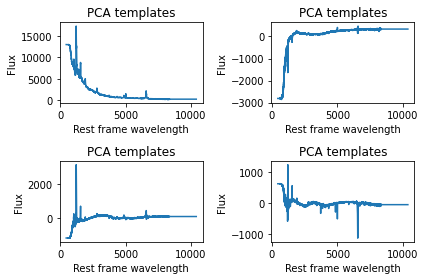

In [8]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
for i in range(axs.size):
    axs[i].plot(pca_templates.wave, pca_templates.flux[i, :])
    axs[i].set_title('PCA templates')
    axs[i].set_ylabel('Flux')
    axs[i].set_xlabel('Rest frame wavelength')
fig.tight_layout()

In [9]:
# TODO: extend in the infrared? at the moment this is naive constant interpolation...

In [10]:
filternames = ["decam_g", "decam_r", "decam_z", "wise_w1", "wise_w2"]
filterdir = "/home/bl/Dropbox/repos/sedpy/sedpy/data/filters" # may need to be changed to data directory in sedpy or spectrophotometricpca
filter_list = observate.load_filters(filternames, directory=filterdir)

lambda_aa, f_lambda_aa = pca_templates.wave, pca_templates.flux
speedoflight = 3e18
f_nu_aa = f_lambda_aa * lambda_aa ** 2 / speedoflight

num_templates = f_lambda_aa.shape[0]
num_redshifts = 400
num_bands = len(filternames)
redshift_grid = onp.linspace(0.0, 4.0, num_redshifts+1)[1:] # redshift grid (skip 0)

#redshifted_photometric_fluxes = onp.zeros((num_redshifts, num_templates, num_bands))
#redshift_factors = onp.zeros((num_redshifts, num_templates))
#for i in range(num_templates):
#    redshifted_photometric_fluxes[:, i, :], _, redshift_factors[:, i] = get_redshifted_photometry(
#        lambda_aa, f_lambda_aa[i, :], redshift_grid, filter_list
#    )
# don't understand why the above doesn't work, but the approach below does,
#although perhaps involving much bigger matrices...
(
    transfer_functions_f_lambda,
    redshift_factors,
) = build_restframe_photometric_transferfunction(
    redshift_grid, lambda_aa, filter_list, f_lambda=True
)
print(transfer_functions_f_lambda.shape, f_lambda_aa.shape)
redshifted_photometric_fluxes = onp.sum(
    transfer_functions_f_lambda[:, None, :, :] * f_lambda_aa[None, :, :, None], axis=2
)
# in case...
#ind = np.isnan(redshifted_photometric_fluxes)
#redshifted_photometric_fluxes[ind] = 0

(400, 13637, 5) (4, 13637)


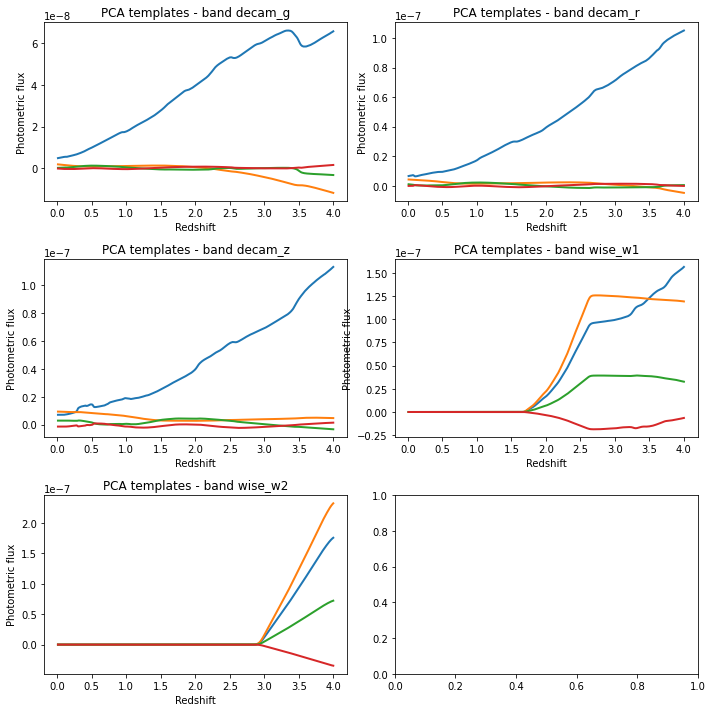

In [12]:
fig, axs = plt.subplots(num_bands//2 + 1, 2, figsize=(10, 10))
axs = axs.ravel()
for i in range(num_bands):
    axs[i].plot(redshift_grid, redshifted_photometric_fluxes[:, :, i], lw=2)
    axs[i].set_title('PCA templates - band '+filternames[i])
    axs[i].set_ylabel('Photometric flux')
    axs[i].set_xlabel('Redshift')
fig.tight_layout()
# not so easy to visualise because fluxes vary by orders of magnitude, 
# and cannot really visualize magnitudes or colors because the fluxes & components go negative.

In [13]:
# Generate noiseless data
nobj = 2000
key = jax.random.PRNGKey(42)

# true linear parameters, per object
theta_truth = jax.random.normal(key, shape=(nobj, num_templates))
redshifts_truth = jax.random.uniform(key, shape=(nobj, ), minval=redshift_grid[0], maxval=redshift_grid[-1])

redshifts_truth_indices = np.argmin((redshifts_truth[:, None] - redshift_grid[None, :])**2, axis=1)

# nobj, num_templates, numBands
redshifted_true_photometric_fluxes_at_z = redshifted_photometric_fluxes[redshifts_truth_indices, :, :] 

# nobj, numBands
obs_photometry_truth = np.sum(theta_truth[:, :, None] * redshifted_true_photometric_fluxes_at_z, axis=1)

In [14]:
# Generate noisy data
obs_photometry_std = np.abs(obs_photometry_truth / 1e2) # arbitrary, 1%
obs_photometry_invvar = np.where(obs_photometry_std == 0, 0, obs_photometry_std ** (-2.0))
obs_photometry_loginvvar = np.where(obs_photometry_invvar == 0, 0, np.log(obs_photometry_invvar))
noise = obs_photometry_std * jax.random.normal(key, (nobj, num_bands))
obs_photometry = obs_photometry_truth + noise

# Training

We need to work out a reasonable prior to use for the PCA coefficients.
We can simply look at the training data, compute the best fit PCA coefficients at the spectroscopic redshift, and measure their distributions.


In [15]:
# flat prior on PCA coefficients for now, using true coefficients
log_likelihoods, theta_map_at_z, theta_std_at_z =\
    logmarglike_lineargaussianmodel_onetransfer_jitvmap(
        redshifted_true_photometric_fluxes_at_z,# model fluxes at spectroscopic redshift
        obs_photometry, obs_photometry_invvar, obs_photometry_loginvvar # data
    )

In [16]:
np.sum(np.isnan(theta_map_at_z), axis=0), np.sum(np.isinf(theta_map_at_z), axis=0), np.sum(~np.isfinite(log_likelihoods))
# in this fake data, the noise model and range of magnitudes are not very realistic, and this causes some nans.
# in the real data this should be better, and there should be no nan values.
# if there are any, this requires investigation (this may simply be due to numerical issues,
# which could be fixed by being careful with the overall scaling of the model and the data.)

(DeviceArray([196, 172,  42,  42], dtype=int32),
 DeviceArray([  2,  26, 156, 156], dtype=int32),
 DeviceArray(198, dtype=int32))

In [17]:
# Temporary fix! Will need to understand where nans are from, for 
# the binned_statistic function below to work.
theta_map_at_z = onp.array(theta_map_at_z) # convert from jax array to numpy array, for next line to work.
theta_map_at_z[~np.isfinite(theta_map_at_z)] = 0

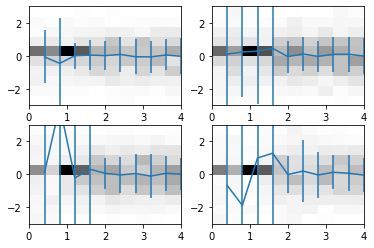

In [18]:
from scipy.stats import binned_statistic

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
for i in range(4):
    axs[i].hist2d(redshifts_truth, theta_map_at_z[:, i], cmap="Greys", range=[[0, 4], [-3, 3]]) 
    binned_means, bin_edges, _ = binned_statistic(redshifts_truth, theta_map_at_z[:, i], statistic='mean')
    binned_stds, _, _ = binned_statistic(redshifts_truth, theta_map_at_z[:, i], statistic='std')
    axs[i].errorbar(bin_edges[1:], binned_means, binned_stds)
    # plotting range need to be adapted.
# could also use the errors theta_std, but probably unnecessary.
# may need to adjust number of bins to minimize noise.

In [19]:
# naive zero mean, unit gaussian prior
mu = np.zeros((nobj, num_templates))
muinvvar = np.ones((nobj, num_templates))
logmuinvvar = np.where(muinvvar == 0, 0, np.log(muinvvar))

In [20]:
# prior measured from training set:
mu = np.nanmean(theta_map_at_z, axis=0) 
mustd = np.nanstd(theta_map_at_z, axis=0)

mustd = np.clip(mustd, 0, 2) ## need to remove this ; 
#this is only to cap the errors, which are overestimated because not deconvolved, see note below.

print(mu, mustd)
# will need to check if nans are common and problematic. For now ignoring them.
muinvvar = mustd ** -2.0
logmuinvvar = np.where(muinvvar == 0, 0, np.log(muinvvar))

# Ideally: rather than a unique Gaussian prior,
# fit a simple model to the data, say linear as a function of redshift.
# Then use this model (possibly via interpolation) in the loop below when computing the redshift pdfs.
# For example, the binned_statistics above can be such a model (a linear polynomial).
# If it isn't too noisy, it could be used directly below. Otherwise, fitting a line to it would work.
# (to the mean and std separately, as a function of redshift)

# finally, the prior is per object, which in the simplest case is redshift independent,
# so we can do to have arrays of shape (nobj, num_components)
# but this could come from interpolation if the prior model was more sophisticated.
mu = mu[None, :] * np.ones((nobj, 1)) 
muinvvar = muinvvar[None, :] * np.ones((nobj, 1)) 
logmuinvvar = logmuinvvar[None, :] * np.ones((nobj, 1)) 

[-0.04631329  0.13064641  0.4245116   0.03825572] [1.3180113 2.        2.        2.       ]


In [21]:
# worth noting that the stddev of the prior is *over* estimated here.
# this is because this method returns the best fit PCA coefficients as well as an error covariance matrix for those.
# Ideally one would propagate this covariance and *deconvolve* the PCA coefficients.
# This could be achieved directly with XDGMM or xdqso!
# in the fake example above, in the limit of many objects, one should recover a zero-mean unit gaussian.
# when taking the stddev of theta_map, it is obvious that the result is much larger, because it is not deconvolved.

# Apply to get redshift posteriors

In [22]:
obs_photometry_std = obs_photometry_truth / 1e2
obs_photometry_invvar = np.where(obs_photometry_std == 0, 0, obs_photometry_std ** (-2.0))
obs_photometry_loginvvar = np.where(obs_photometry_invvar == 0, 0, np.log(obs_photometry_invvar))
noise = obs_photometry_std * jax.random.normal(key, (nobj, num_bands))
obs_photometry = obs_photometry_truth + noise


log_likelihoods = onp.zeros((nobj, num_redshifts))
theta_map = onp.zeros((nobj, num_redshifts, num_templates))

for iz in range(num_redshifts):
    redshifted_photometric_fluxes_at_z = redshifted_photometric_fluxes[iz, :, :] * np.ones((nobj, 1, 1))
    if True: # with Gaussian prior on PCA coefficients
        
        log_likelihoods[:, iz], theta_map[:, iz], _ =\
            logmarglike_lineargaussianmodel_twotransfers_jitvmap(
                redshifted_photometric_fluxes_at_z, 
                obs_photometry, obs_photometry_invvar, obs_photometry_loginvvar,
                mu, muinvvar, logmuinvvar
            )
    else: # flat prior on PCA coefficients; doesn't work well.
        log_likelihoods[:, iz], theta_map[:, iz], _ =\
            logmarglike_lineargaussianmodel_onetransfer_jitvmap(
                redshifted_photometric_fluxes_at_z, 
                obs_photometry, obs_photometry_invvar, obs_photometry_loginvvar
            )

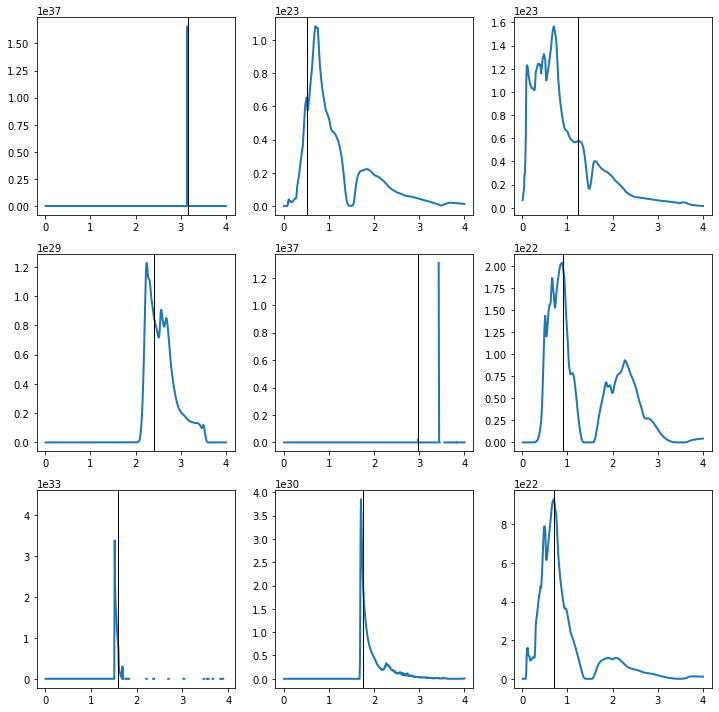

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()
for i in range(axs.size):
    axs[i].plot(redshift_grid, np.exp(log_likelihoods[i, :]), lw=2)
    axs[i].axvline(redshifts_truth[i], c='k', lw=1)
fig.tight_layout()

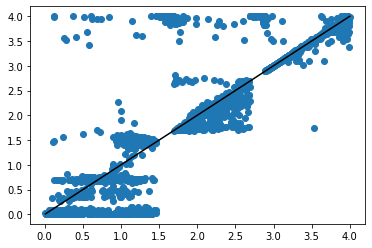

In [24]:
redshifts_estimates = np.take(redshift_grid, np.argmax(log_likelihoods, axis=1))
plt.scatter(redshifts_truth, redshifts_estimates)
plt.plot(redshift_grid, redshift_grid, c='k')